# LICENSE

Copyright Amazon.com, Inc. or its affiliates. All Rights Reserved.
SPDX-License-Identifier: MIT-0

Permission is hereby granted, free of charge, to any person obtaining a copy of this
software and associated documentation files (the 'Software'), to deal in the Software
without restriction, including without limitation the rights to use, copy, modify,
merge, publish, distribute, sublicense, and/or sell copies of the Software, and to
permit persons to whom the Software is furnished to do so.

THE SOFTWARE IS PROVIDED 'AS IS', WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT
HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION
OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE
SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


# Getting started with Amazon Braket

In this hello-world tutorial we prepare a maximally entangled Bell state between two qubits. We then run our circuit on a local simulator and obtain the results.

In [ ]:
# general imports
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import string
import time
import numpy as np

# AWS imports: Import Braket SDK modules
from braket.circuits import Circuit, Gate, Observable, Noise
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

## Build a circuit

Let's build a Bell state with two qubits. By calling `Circuit()` we create an empty circuit, and we can just add gates to the circuit. 

In [ ]:
# build a Bell state with two qubits. Here 'cnot(control=0, target=1)' can be simplified as 'cnot(0,1)'
bell = Circuit().h(0).cnot(control=0, target=1)

## Submit the circuit to the local simulator and obtain the results

Here we submit our circuit to the local simulator and obtain the results.

In [ ]:
# set up device
device = LocalSimulator()

# run circuit
result = device.run(bell, shots=1000).result()
# get measurement shots
counts = result.measurement_counts
# print counts
print(counts)

In [ ]:
# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');

## Running larger circuits on managed simulators

Apart from the local simulator, you can also run your circuit on a managed simulator. This approach adds some latency overhead, but is beneficial for larger circuits by leveraging the optimized cloud hardware infrastructure. Moreover, all your results will be stored reliably in S3. 

__NOTE__: If you are working with the local simulator ```LocalSimulator()``` you do not need to specify any S3 location. However, if you are using a managed device or any QPU devices you need to specify the S3 location where your results will be stored. Remember that bucket names for Amazon Braket always begin with `"amazon-braket-"`. In this case, you must replace the API call ```device.run(circuit, ...)``` below with ```device.run(circuit, s3_folder, ...)```, where `s3_folder = (my_bucket, my_prefix)`. If you don't specify the S3 location, default S3 folder, where all inputs and outputs for your tasks are saved, follows the convention `amazon-braket-<region>-<account number>`. 

### Prepare a GHZ State

In [ ]:
# function to build a GHZ state
def ghz_circuit(n_qubits):
    """
    function to return a GHZ circuit ansatz
    input: number of qubits
    """

    # instantiate circuit object
    circuit = Circuit()
    
    # add Hadamard gate on first qubit
    circuit.h(0)

    # apply series of CNOT gates
    for ii in range(0, n_qubits-1):
        circuit.cnot(control=ii, target=ii+1)

    return circuit

The GHZ state is a quantum superposition of all subsystems being in state 0 with all of them being in state 1 (as often discussed in the famous Gedanken experiment of a cat being dead and alive at the same time). The GHZ state is a maximally entangled quantum state. 

To prepare this state, build and run the following circuit using a single-qubit Hadamard gate (denoted as H) acting on the first qubit followed by a series of two-qubit CNOT gates: 

<div>
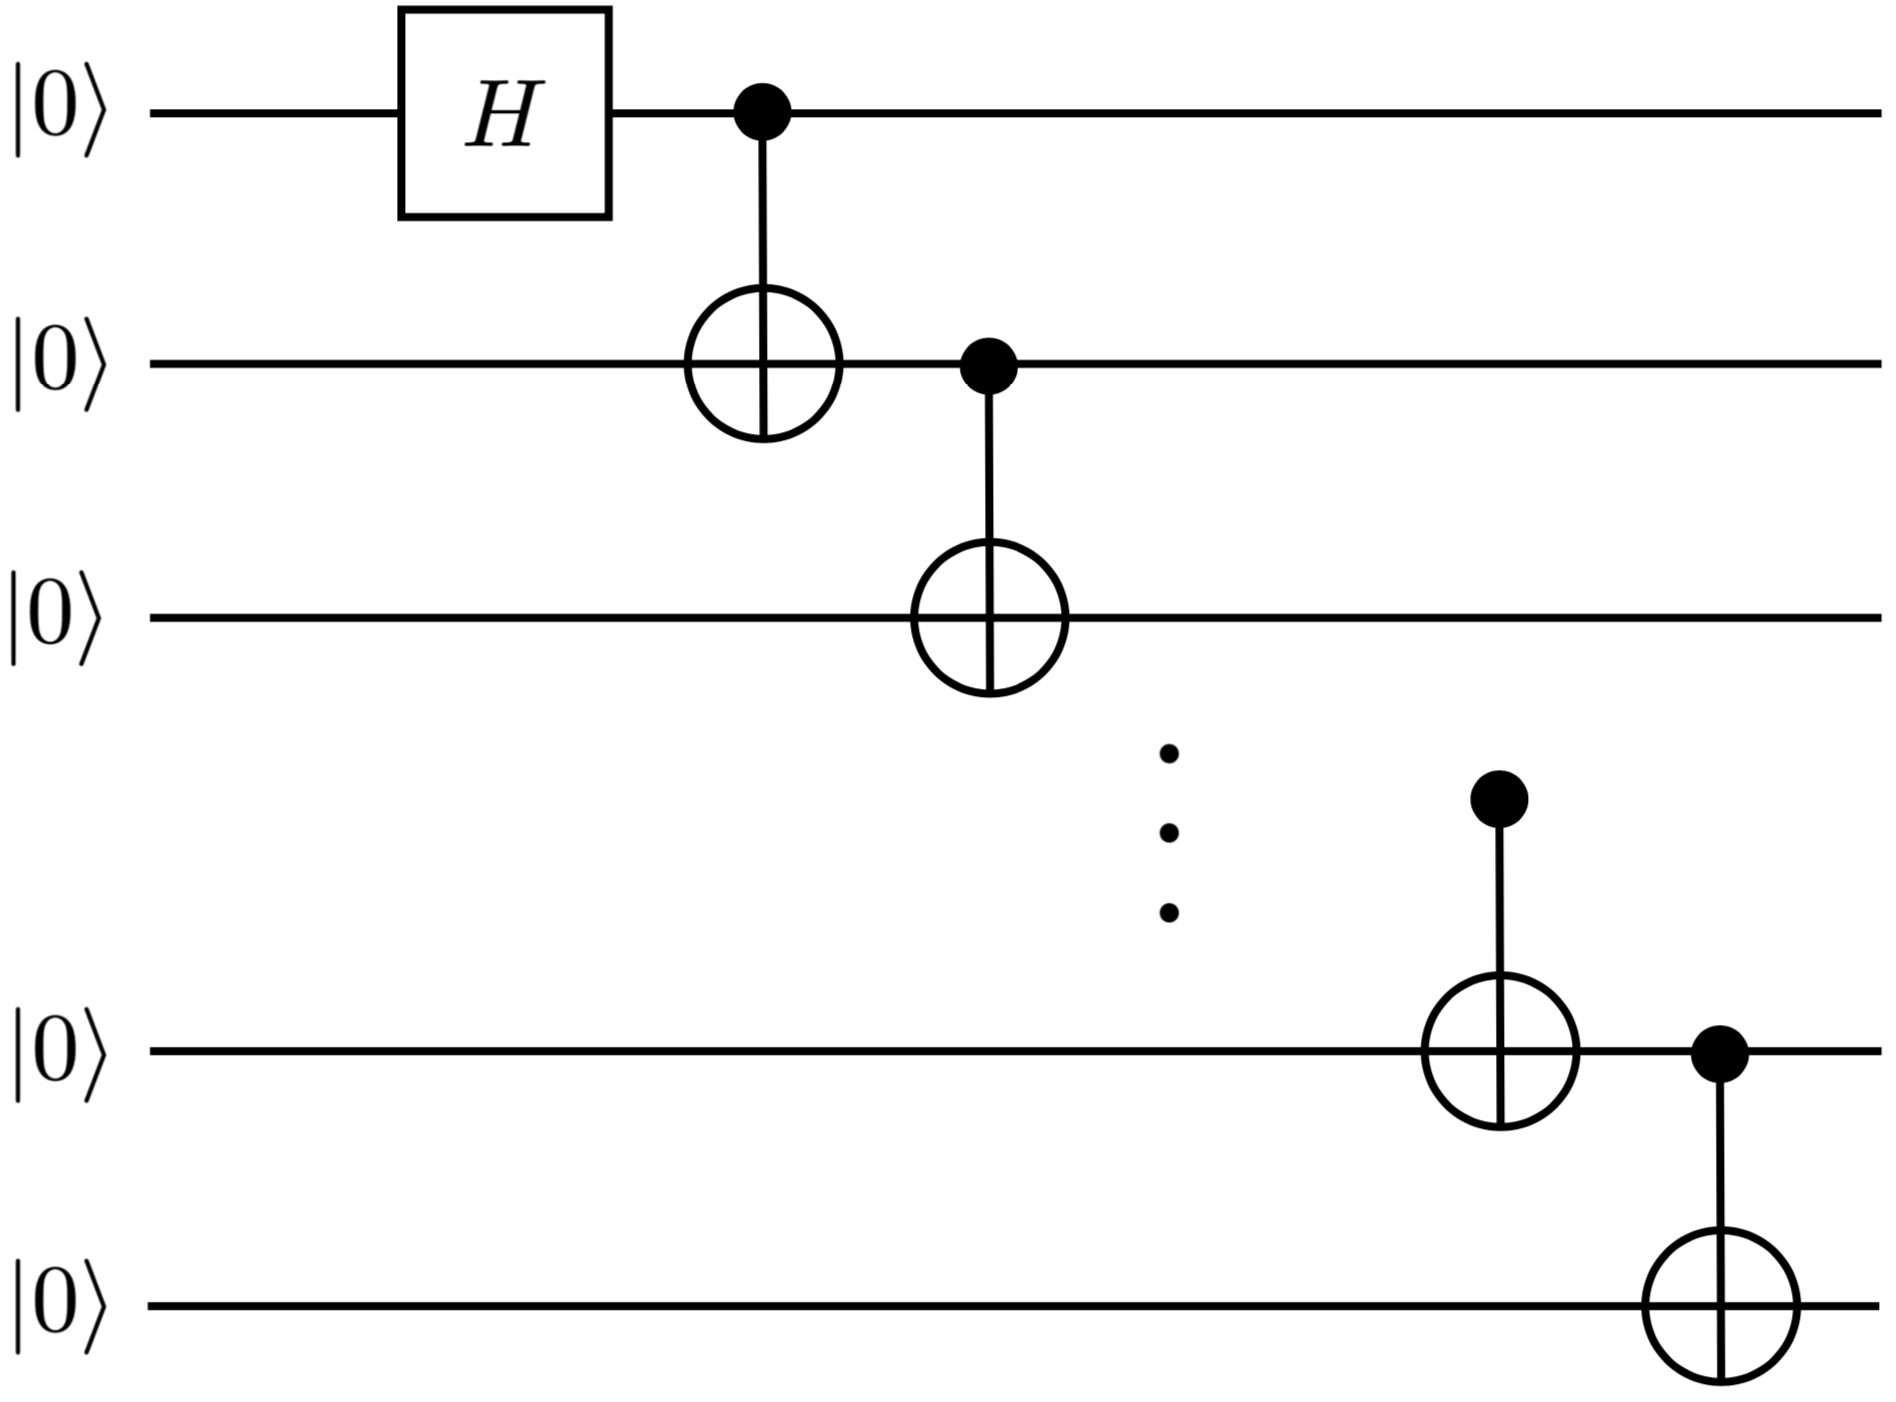
</div>

Amazon Braket provides two managed simulators: SV1 and TN1. SV1 calculates and keeps track of the full state vector evolution, supporting simulations of circuits with up to 34 qubits. TN1 is a tensor-network simulator, where each gate in a circuit is represented as a tensor. Compared with SV1, TN1 can simulate a larger number of qubits for circuits with local gates or other special structure, but typically is slower for circuits with long-range or all-to-all gate structure.

### State Vector Simulator

In [ ]:
# set up the managed simulator SV1
device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

In [ ]:
# define a 15-qubit GHZ circuit
n_qubits = 15
ghz = ghz_circuit(n_qubits)

# run GHZ circuit on SV1
result = device.run(ghz, shots=1000).result()
counts = result.measurement_counts
print(counts)

# plot using Counter
plt.bar(counts.keys(), counts.values());
plt.xlabel('bitstrings');
plt.ylabel('counts');  

# print counts of all-zero-string
print('Counts for all-zero bitstring:', counts['0'*n_qubits])
# print counts of all-one-string
print('Counts for all-one bitstring:', counts['1'*n_qubits])

__NOTE__: Use unique task ID to look up task details in AWS console.

In [ ]:
# print unique TASK ID (task = execution of individual circuit)
task_id = result.task_metadata.id
# recover other metadata information such as number of qubits
n = result.task_metadata.deviceParameters.paradigmParameters.qubitCount
print('Task ID:', task_id)
print('Number of qubits:', n)

## Running quantum circuits on QPU devices

In this section we show how to run circuits on QPU devices. We can run our circuit on both the superconducting machine from Rigetti and the ion-trap machine provided by IonQ. As shown below, one can seamlessly swap between different devices without any modifications to the circuit definition, by just re-defining the device object. We also show how to recover results using the unique ARN associated with every task. This tool is useful in order to deal with potential delays if your quantum task sits in the queue for some time waiting for execution. 

### Quantum Hardware: Rigetti

Next we submit the Bell pair circuit to the superconducting quantum chip provided by Rigetti. Depending on our position in the queue, we may have to wait for some time till our circuit is actually run. However, thanks to asynchronous execution, we can always come back and recover the results by providing the unique ID associated with every task. 

In [ ]:
# set up device
rigetti = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1")

# create a clean circuit with no result type attached.
#(This is because some result types are only supported when shots=0)
bell = Circuit().h(0).cnot(0, 1)  

# add the Z \otimes Z expectation value
bell.expectation(Observable.Z() @ Observable.Z(), target=[0,1])

# run circuit 
rigetti_task = rigetti.run(bell, shots=1000)

# get id and status of submitted task
rigetti_task_id = rigetti_task.id
rigetti_status = rigetti_task.state()
# print('ID of task:', rigetti_task_id)
print('Status of task:', rigetti_status)

The task is submitted and we can regularly (or irregularly) check the status of this task by executing the following cell. You may easily build logic around this query to wait for this task to complete before your code proceeds. 

In [ ]:
# print status
status = rigetti_task.state()
print('Status of (reconstructed) task:', status)

We can now search in the console for the Rigetti task in us-west-1 Region. 

### Quantum Hardware: IonQ

Finally, we submit our example Bell state circuit to IonQ. To this end, we set the device as AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice"). This task may not readily be executed but enter a queue for this specific machine. While we can interrupt our kernel (and work on something else), we can always recover our results using the unique ID of this task. 

In [ ]:
# Setup yourself the same circuit using the IonQ device,
# specifying the device Amazon Resource Name and number of shots.

# setup device
ionq = AwsDevice("INSERT_ARN_HERE")

# run circuit
ionq_task = ionq.run(bell, shots=INSERT_N_SHOTS_HERE)

# get id and status of submitted task
ionq_task_id = ionq_task.id
ionq_status = ionq_task.state()
# print('ID of task:', ionq_task_id)
print('Status of task:', ionq_status)

In [ ]:
# print status
status = ionq_task.state()
print('Status of (reconstructed) task:', status)

### Task Recovery

By simply grabbing the unique task ID associated with the quantum tasks we have submitted above, we can recover this task at any point in time and (once the status is completed) visualize and analyze the corresponding results. Note that apart from other metadata, you can retrieve the compiled circuit that was actually run on the Rigetti device. More information about the compiling process can be found [here](https://pyquil-docs.rigetti.com/en/v2.22.0/compiler.html#partial). 

#### Rigetti

In [ ]:
# recover task
task_load = AwsQuantumTask(arn=rigetti_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) task:', status)
print('\n')
# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    rigetti_results = task_load.result()
    # print(rigetti_results)
    
    # get all metadata of submitted task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['deviceArn']
    # print example metadata
    print("{} shots taken on machine {}.\n".format(shots, machine))
    
    # get the compiled circuit
    print("The compiled circuit is:\n", rigetti_results.additional_metadata.rigettiMetadata.compiledProgram)
    
    # get measurement counts
    rigetti_counts = rigetti_results.measurement_counts
    print('Measurement counts:', rigetti_counts)

    # plot results: see effects of noise
    plt.bar(rigetti_counts.keys(), rigetti_counts.values())
    plt.xlabel('bitstrings')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig('rigetti.png', dpi=700)
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')

#### IonQ

In [ ]:
# recover task
task_load = AwsQuantumTask(arn=ionq_task_id)

# print status
status = task_load.state()
print('Status of (reconstructed) task:', status)

# wait for job to complete
# terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
if status == 'COMPLETED':
    # get results
    results = task_load.result()
    # print(ionq_results)
    
    # get all metadata of submitted task
    metadata = task_load.metadata()
    # example for metadata
    shots = metadata['shots']
    machine = metadata['deviceArn']
    # print example metadata
    print("{} shots taken on machine {}.".format(shots, machine))
    
    # get measurement counts
    counts = results.measurement_counts
    print('Measurement counts:', counts)

    # plot results: see effects of noise
    plt.bar(counts.keys(), counts.values())
    plt.xlabel('bitstrings')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig('bell_ionq.png', dpi=700)
    
elif status in ['FAILED', 'CANCELLED']:
    # print terminal message 
    print('Your task is in terminal status, but has not completed.')

else:
    # print current status
    print('Sorry, your task is still being processed and has not been finalized yet.')

### Taking it further

Check gate compatibility across devices, so you can write circuits that can run without any modification across devices.

In [ ]:
# print all (the usual suspects) available gates currently available within SDK
gate_set = [attr for attr in dir(Gate) if attr[0] in string.ascii_uppercase]
print('Gate set supported by SDK:\n', gate_set)
print('\n') 

# the Rigetti device
device = AwsDevice("arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1")
supported_gates = device.properties.action['braket.ir.jaqcd.program'].supportedOperations
# print the supported gate set
print('Gate set supported by the Rigetti device:\n', supported_gates)
print('\n') 

# the IonQ device
device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")
supported_gates = device.properties.action['braket.ir.jaqcd.program'].supportedOperations
# print the supported gate set
print('Gate set supported by the IonQ device:\n', supported_gates)
print('\n') 

# the Oxford device
device = AwsDevice("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")
supported_gates = device.properties.action['braket.ir.jaqcd.program'].supportedOperations
# print the supported gate set
print('Gate set supported by the Oxford device:\n', supported_gates)